### Car Tracking project by Emil Wåreus


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import time
from skimage.feature import hog 

## Extract Features


In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [3]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else: feature_image = np.copy(image)      
        
        if cspace == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
       
        features.append(hog_features)
        
        feature_image=cv2.flip(feature_image,1) 
        if cspace == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
       
        features.append(hog_features)
        
    # Return list of feature vectors
    return features
        

## Lets train a classifier!! 

In [4]:
#Load the data
import glob
cars = []
none_cars = []
for img in glob.glob('*data/non-vehicles/*/*.png'):
    none_cars.append(img)
    
    
for img in glob.glob("data/vehicles/*/*.png"):
    cars.append(img)


print("Number of cars : ", len(cars))
print("Number of none-cars : ", len(none_cars))

Number of cars :  8792
Number of none-cars :  8968


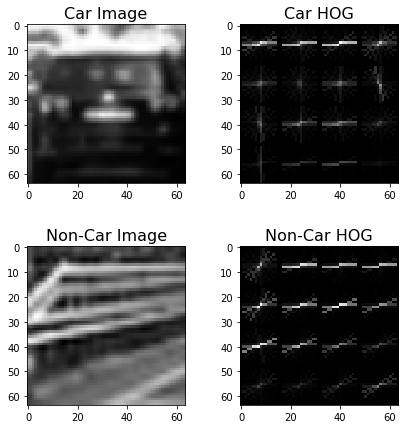

...


In [39]:
#Lets look at the features 
cspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

from random import randint


car_img = mpimg.imread(cars[randint(0,len(cars))])
car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
_, car_dst = get_hog_features(car_img, 
                              orient, pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=True)
noncar_img = mpimg.imread(none_cars[randint(0,len(none_cars))])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)
_, noncar_dst = get_hog_features(noncar_img, 
                              orient, pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img, cmap='gray')
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img, cmap='gray')
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()
print('...')

In [40]:
car_features = extract_features(cars, 
                                cspace=cspace, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

print("Number of cars : ", len(car_features))
none_car_features = extract_features(none_cars, 
                                cspace=cspace,
                                orient=orient, 
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)


print("Number of none-cars : ", len(none_car_features))



Number of cars :  17584
Number of none-cars :  17936


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import sklearn


print(len(car_features) + len(none_car_features))


SVC = LinearSVC() 
#Building a classifier:

X = np.vstack((car_features, none_car_features)).astype(np.float64)
print(len(X))

Y = np.hstack((np.ones(len(car_features)), np.zeros(len(none_car_features))))
print(len(Y))

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
#print(len(scaled_X))
#train batch
SVC.fit(X_train, Y_train)
print(" Done")


35520
35520
35520
 Done


In [42]:
#Train support vector Machine

print("Feature len : ", len(X[0]))
print("Accuracy of SVC : ", round(SVC.score(X_test, Y_test), 5))


Feature len :  1188
Accuracy of SVC :  0.98297


## Sliding Window

In [43]:
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
 # If x and/or y start/stop positions not defined, set to image size
    
    if x_start_stop[0] == None:
        
        x_start_stop = [0, x_start_stop[1]]
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop =  [0, y_start_stop[1]]
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


#Finda car: 
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel , svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #Cspace
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'GRAY':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: ctrans_tosearch = np.copy(image) 
        
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            # Extract the image patch
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles




In [44]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


### Let's try it out! 

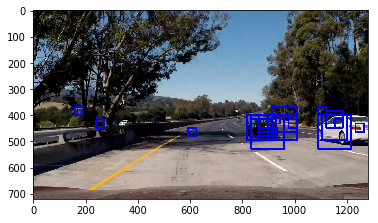

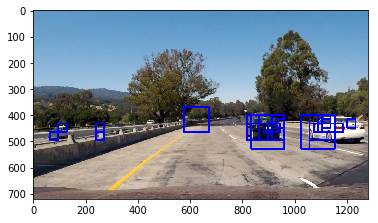

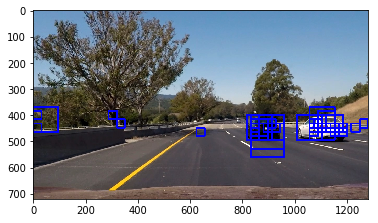

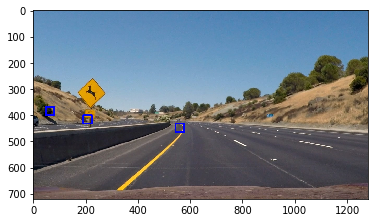

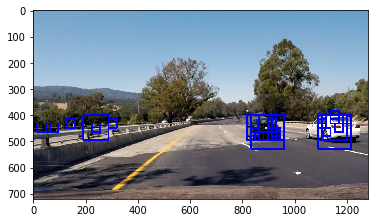

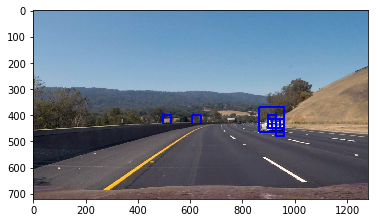

In [46]:
#After alot of itterations this combination was deemed good enough

def get_rect(img,cspace, hog_channel , SVC,
             X_scaler, orient, pix_per_cell, 
             cell_per_block):
    
    rectangles = []
    ystart = 368
    ystop = 432
    scale = 0.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))
    
    ystart = 384
    ystop = 448
    scale = 0.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))

    
    ystart = 400
    ystop = 464
    scale = 0.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))

    ystart = 416
    ystop = 480
    scale = 0.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    
    ystart = 432
    ystop = 496
    scale = 0.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    
    ystart = 368
    ystop = 432
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))
    
    ystart = 384
    ystop = 448
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))

    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    
    ystart = 432
    ystop = 496
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    
    ystart = 464
    ystop = 528
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 368
    ystop = 464
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

   
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, 
                               cspace, hog_channel , SVC, 
                               X_scaler, orient, pix_per_cell, 
                               cell_per_block))

   
    rectangles = [item for sublist in rectangles for item in sublist] 

    return rectangles


for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    
    rectangles = get_rect(img, 
                           cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)
    
    img_w_boxes = draw_boxes(img_out, rectangles, color = (255, 0 , 0), thick = 5)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()

### Testing the classifier 

Great! The classifier works okay. Now we need to add a heat map to get rid of the multiple classifications and false positives. We need to add some other scaling as well since the last image didn't classify correctly

In [47]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(img, labels):
    
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        size = np.absolute(np.max(nonzerox)-np.min(nonzerox))*np.absolute(np.min(nonzeroy)-np.max(nonzeroy))
        
        
        #Filter size of box! 
        if((size > 3000) &
          ((np.absolute(np.max(nonzerox)-np.min(nonzerox))
           /np.absolute(np.min(nonzeroy)-np.max(nonzeroy))) > 0.7 )):
            # Draw the box on the image
            #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            bboxes.append(bbox)
        
       
    # Return the image
    return bboxes

    
def get_heated_boxes(img, box_list, threshold = 2):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    
    return get_labeled_bboxes(np.copy(img), labels)


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def calc_average_boxes (hot_boxes, strength):
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop(0)
        hb = AverageHotBox(b)
        while hb.join(hot_boxes):
            pass
        avg_boxes.append(hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes


class AverageHotBox ():
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
       
        return self.detected_count
    
    def get_box (self):
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

class HotQueue():
    
    def __init__ (self):
        self.queue_len = 10 
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        
        if (len(self.last_boxes) > self.queue_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = HotQueue()

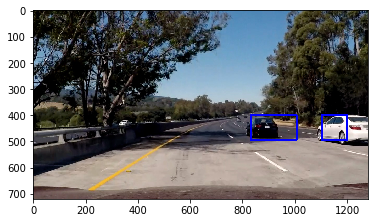

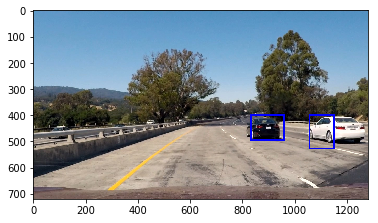

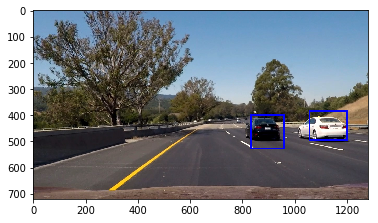

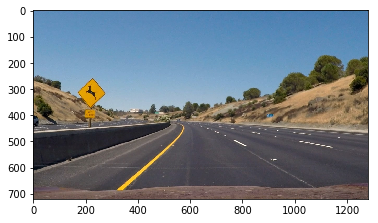

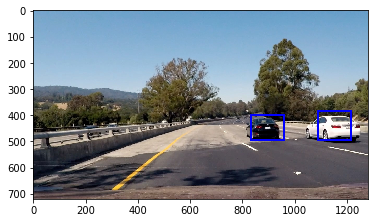

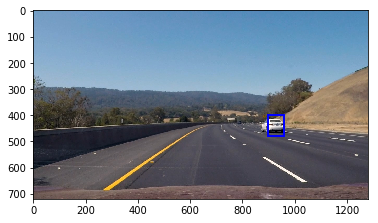

In [48]:
#Lets test with heat added:
i=1

imgs = []
for image_path in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(image_path)
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)
  
    boxes = get_heated_boxes(img_out, rectangles, threshold=1)
    
    
    img_w_boxes = draw_boxes(img_out, boxes, color = (255, 0 , 0), thick = 5)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    imgs.append(cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB))
    plt.show()
    i = i+1

Good Enough! 

In [49]:
#Make Video: 
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    boxes = get_heated_boxes(img_out, rectangles, threshold=1)
    last_hot_boxes.put_hot_boxes(boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 3)
    
    img_w_boxes = draw_boxes(img_out, avg_boxes)
   
    return img_w_boxes

In [ ]:
from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_5.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video project_video_proc_5.mp4
[MoviePy] Writing video project_video_proc_5.mp4


  3%|▎         | 43/1261 [01:21<38:46,  1.91s/it]

In [16]:
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    boxes = get_heated_boxes(img_out, rectangles, threshold=1)
    last_hot_boxes.put_hot_boxes(boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 5)
    
    img_w_boxes = draw_boxes(img_out, avg_boxes)
   
    return img_w_boxes

from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_6.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video project_video_proc_6.mp4
[MoviePy] Writing video project_video_proc_6.mp4


100%|█████████▉| 1260/1261 [16:34<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_6.mp4 

CPU times: user 15min 16s, sys: 1min 31s, total: 16min 47s
Wall time: 16min 35s


In [17]:
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    #boxes = get_heated_boxes(img_out, rectangles, threshold=1)
    last_hot_boxes.put_hot_boxes(rectangles)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 20)
    
    img_w_boxes = draw_boxes(img_out, avg_boxes)
   
    return img_w_boxes

from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_7_rect.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc_7_rect.mp4
[MoviePy] Writing video project_video_proc_7_rect.mp4


100%|█████████▉| 1260/1261 [16:10<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_7_rect.mp4 

CPU times: user 15min 3s, sys: 1min 19s, total: 16min 23s
Wall time: 16min 11s


In [18]:
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    #boxes = get_heated_boxes(img_out, rectangles, threshold=1)
    last_hot_boxes.put_hot_boxes(rectangles)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 15)
    
    img_w_boxes = draw_boxes(img_out, avg_boxes)
   
    return img_w_boxes

from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_8_rect.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc_8_rect.mp4
[MoviePy] Writing video project_video_proc_8_rect.mp4


100%|█████████▉| 1260/1261 [15:57<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_8_rect.mp4 

CPU times: user 15min 2s, sys: 1min 7s, total: 16min 10s
Wall time: 15min 58s


In [19]:
def full_pipeline(img):
    img_out = img.copy()
    
    rectangles = get_rect(img, cspace, hog_channel , SVC, 
                           X_scaler, orient, pix_per_cell, 
                           cell_per_block)

    boxes = get_heated_boxes(img_out, rectangles, threshold=0)
    last_hot_boxes.put_hot_boxes(boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 6)
    
    img_w_boxes = draw_boxes(img_out, avg_boxes)
   
    return img_w_boxes

from moviepy.editor import VideoFileClip

output_v = 'project_video_proc_9.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(full_pipeline)
%time clip.write_videofile(output_v, audio=False)


[MoviePy] >>>> Building video project_video_proc_9.mp4
[MoviePy] Writing video project_video_proc_9.mp4


100%|█████████▉| 1260/1261 [16:17<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_9.mp4 

CPU times: user 15min 14s, sys: 1min 15s, total: 16min 29s
Wall time: 16min 17s
